<a href="https://colab.research.google.com/github/AmilcarArmmand/CSC-481_Project/blob/main/BreakHis_481_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Dropout, Rescaling,GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
file_path="/content/drive/MyDrive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"
batch_size = 16
image_size = 224,224
#preprocessing the image
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)



In [ ]:
# Separate validation generator with only rescaling
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
# Training data
train_data = train_datagen.flow_from_directory(
    file_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data
validation_data = validation_datagen.flow_from_directory(
    file_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# class information
print(f"Classes found: {train_data.class_indices}")
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {validation_data.samples}")

Found 6328 images belonging to 2 classes.
Found 1581 images belonging to 2 classes.
Classes found: {'benign': 0, 'malignant': 1}
Training samples: 6328
Validation samples: 1581


In [ ]:
def create_model(base_model_type='DenseNet121'):
    if base_model_type == 'DenseNet121':
        base_model = DenseNet121(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif base_model_type == 'EfficientNetB3':
        base_model = EfficientNetB3(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )
    elif base_model_type == 'ResNet50V2':
        base_model = ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

    # top layers trainable
    for layer in base_model.layers[:-30]:  # Freeze most layers
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),  # you can try with different
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])


    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# model creating
model = create_model('DenseNet121')  # Options you may consider i am denseNet121: 'EfficientNetB3' or 'ResNet50V2'
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,332,929 (27.97 MB)

 Trainable params: 936,833 (3.57 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

##Train

In [ ]:
#callbacks to prevent overfitting
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=30,  # Train longer with early stopping/ you can choose as you like
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6872 - auc_1: 0.6777 - loss: 0.6113 - precision_1: 0.7467 - recall_1: 0.8269
Epoch 1: val_accuracy improved from -inf to 0.75206, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 2927s 7s/step - accuracy: 0.6874 - auc_1: 0.6780 - loss: 0.6110 - precision_1: 0.7468 - recall_1: 0.8270 - val_accuracy: 0.7521 - val_auc_1: 0.6996 - val_loss: 0.6088 - val_precision_1: 0.7692 - val_recall_1: 0.9124 - learning_rate: 1.0000e-04
Epoch 2/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.8718 - auc_1: 0.9234 - loss: 0.3235 - precision_1: 0.8907 - recall_1: 0.9275
Epoch 2: val_accuracy improved from 0.75206 to 0.77609, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 224s 564ms/step - accuracy: 0.8718 - auc_1: 0.9234 - loss: 0.3234 - precision_1: 0.8908 - recall_1: 0.9275 - val_accuracy: 0.7761 - val_auc_1: 0.7693 - val_loss: 0.6848 - val_precision_1: 0.7742 - val_recall_1: 0.9512 - learning_rate: 1.0000e-04
Epoch 3/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.9002 - auc_1: 0.9479 - loss: 0.2644 - precision_1: 0.9217 - recall_1: 0.9350
Epoch 3: val_accuracy improved from 0.77609 to 0.80708, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 254s 546ms/step - accuracy: 0.9002 - auc_1: 0.9480 - loss: 0.2643 - precision_1: 0.9217 - recall_1: 0.9351 - val_accuracy: 0.8071 - val_auc_1: 0.8346 - val_loss: 0.5605 - val_precision_1: 0.8495 - val_recall_1: 0.8737 - learning_rate: 1.0000e-04
Epoch 4/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9235 - auc_1: 0.9625 - loss: 0.2235 - precision_1: 0.9372 - recall_1: 0.9523
Epoch 4: val_accuracy improved from 0.80708 to 0.81531, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 207s 524ms/step - accuracy: 0.9235 - auc_1: 0.9625 - loss: 0.2235 - precision_1: 0.9372 - recall_1: 0.9523 - val_accuracy: 0.8153 - val_auc_1: 0.8470 - val_loss: 0.5675 - val_precision_1: 0.8242 - val_recall_1: 0.9290 - learning_rate: 1.0000e-04
Epoch 5/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9308 - auc_1: 0.9726 - loss: 0.1918 - precision_1: 0.9452 - recall_1: 0.9542
Epoch 5: val_accuracy improved from 0.81531 to 0.83934, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 204s 516ms/step - accuracy: 0.9308 - auc_1: 0.9726 - loss: 0.1918 - precision_1: 0.9452 - recall_1: 0.9541 - val_accuracy: 0.8393 - val_auc_1: 0.8953 - val_loss: 0.4126 - val_precision_1: 0.8667 - val_recall_1: 0.9051 - learning_rate: 1.0000e-04
Epoch 6/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9344 - auc_1: 0.9785 - loss: 0.1689 - precision_1: 0.9478 - recall_1: 0.9593
Epoch 6: val_accuracy did not improve from 0.83934
396/396 ━━━━━━━━━━━━━━━━━━━━ 204s 515ms/step - accuracy: 0.9344 - auc_1: 0.9786 - loss: 0.1689 - precision_1: 0.9478 - recall_1: 0.9593 - val_accuracy: 0.8134 - val_auc_1: 0.8333 - val_loss: 0.6854 - val_precision_1: 0.8227 - val_recall_1: 0.9281 - learning_rate: 1.0000e-04
Epoch 7/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9327 - auc_1: 0.9782 - loss: 0.1742 - precision_1: 0.9506 - recall_1: 0.9525
Epoch 7: val_accuracy improved from 0.83934 to 0.85642, saving model to best_model.h5


396/396 ━━━━━━━━━━━━━━━━━━━━ 199s 503ms/step - accuracy: 0.9327 - auc_1: 0.9782 - loss: 0.1742 - precision_1: 0.9506 - recall_1: 0.9525 - val_accuracy: 0.8564 - val_auc_1: 0.9029 - val_loss: 0.4338 - val_precision_1: 0.8724 - val_recall_1: 0.9263 - learning_rate: 1.0000e-04
Epoch 8/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9425 - auc_1: 0.9833 - loss: 0.1490 - precision_1: 0.9556 - recall_1: 0.9603
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: val_accuracy did not improve from 0.85642
396/396 ━━━━━━━━━━━━━━━━━━━━ 199s 502ms/step - accuracy: 0.9425 - auc_1: 0.9833 - loss: 0.1490 - precision_1: 0.9556 - recall_1: 0.9603 - val_accuracy: 0.8463 - val_auc_1: 0.8907 - val_loss: 0.5030 - val_precision_1: 0.8568 - val_recall_1: 0.9318 - learning_rate: 1.0000e-04
Epoch 9/30
396/396 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9571 - auc_1: 0.9892 - loss: 0.1190 - precision_1: 0.9679 - recall_1: 0.9702
Epoch 9: val_accuracy did not im

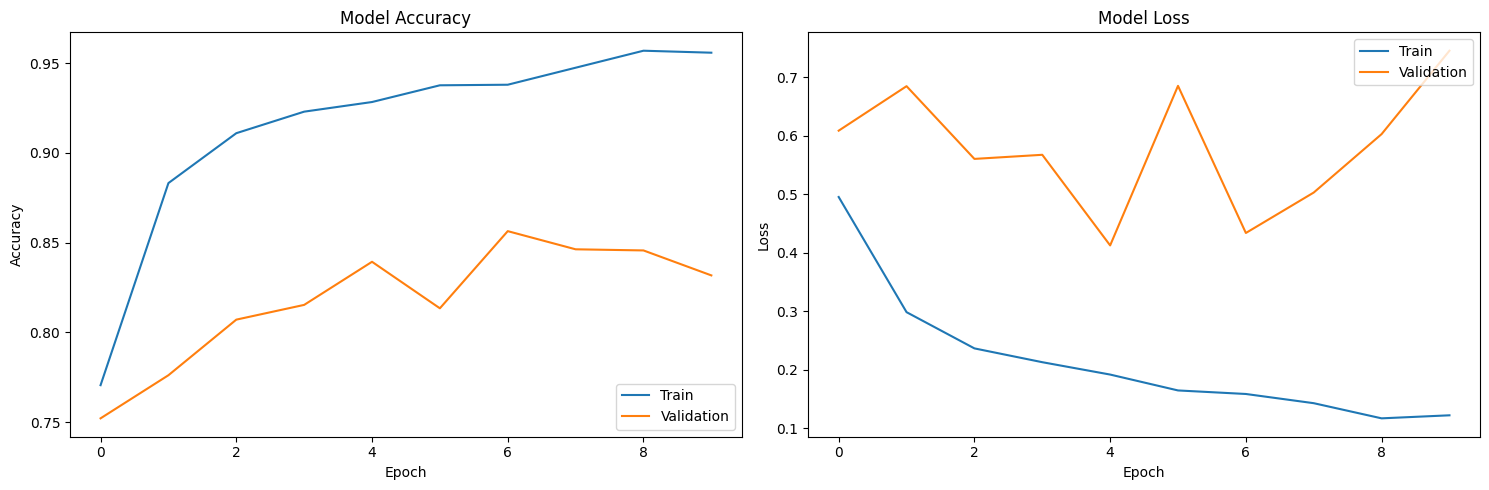

99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.7695 - auc_1: 0.6001 - loss: 0.6013 - precision_1: 0.4771 - recall_1: 0.5976
Test accuracy: 0.8393
Test AUC: 0.8953
Test precision: 0.8667
Test recall: 0.9051


In [ ]:
# Plot
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Evaluate the model
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve_for_generator(model, data_generator):

    data_generator.reset()
    y_true = []
    y_pred = []

    num_batches = len(data_generator)

    for i in range(num_batches):
        x_batch, y_batch = data_generator[i]
        batch_pred = model.predict(x_batch)
        y_true.extend(y_batch)
        y_pred.extend(batch_pred)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if len(y_pred.shape) > 1 and y_pred.shape[1] == 1:
        y_pred = y_pred.flatten()

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    return roc_auc


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━

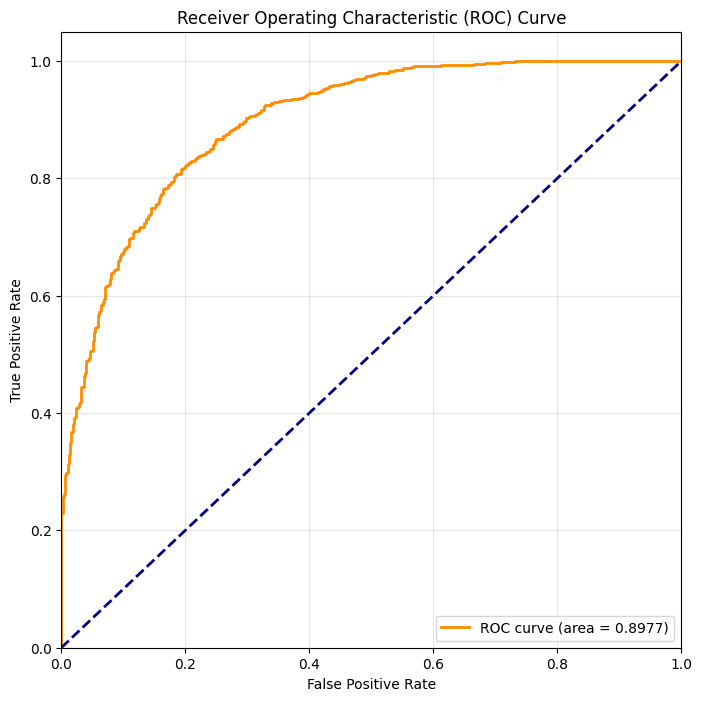

In [ ]:
auc_score = plot_roc_curve_for_generator(model, validation_data)

In [ ]:

#model performance by visualization
def visualize_predictions(model, validation_data, num_images=10, class_names=None):

    validation_data.reset()

    if class_names is None:
        if hasattr(validation_data, 'class_indices'):

            class_names = {v: k for k, v in validation_data.class_indices.items()}
        else:

            class_names = {0: "Negative", 1: "Positive"}

    # Get a batch of images
    images_seen = 0
    plt.figure(figsize=(15, num_images * 2))

    # Process images batch by batch
    for i, (batch_images, batch_labels) in enumerate(validation_data):

        batch_preds = model.predict(batch_images)

        # For each image in the batch
        for j in range(len(batch_images)):
            if images_seen >= num_images:
                break

            #image, true label, and predicted label
            img = batch_images[j]
            true_label = batch_labels[j]

            #different prediction out of 1
            if len(batch_preds.shape) > 1 and batch_preds.shape[1] > 1:

                pred_label = np.argmax(batch_preds[j])
                pred_confidence = batch_preds[j][pred_label]
            else:

                pred_score = batch_preds[j][0] if len(batch_preds.shape) > 1 else batch_preds[j]
                pred_label = 1 if pred_score > 0.5 else 0
                pred_confidence = pred_score if pred_label == 1 else 1 - pred_score


            if isinstance(true_label, np.ndarray) and len(true_label.shape) > 0:
                true_label = np.argmax(true_label)

            true_class = class_names.get(true_label, f"Class {true_label}")
            pred_class = class_names.get(pred_label, f"Class {pred_label}")

            #image and prediction
            plt.subplot(num_images, 2, images_seen * 2 + 1)

            if np.max(img) <= 1.0:
                display_img = img * 255
            else:
                display_img = img

            if display_img.shape[-1] == 1:
                plt.imshow(display_img.reshape(display_img.shape[0], display_img.shape[1]), cmap='gray')
            else:
                plt.imshow(display_img.astype('uint8'))

            plt.title(f"True: {true_class}", fontsize=12)
            plt.axis('off')

            plt.subplot(num_images, 2, images_seen * 2 + 2)

            if display_img.shape[-1] == 1:
                plt.imshow(display_img.reshape(display_img.shape[0], display_img.shape[1]), cmap='gray')
            else:
                plt.imshow(display_img.astype('uint8'))

            color = "green" if pred_label == true_label else "red"
            plt.title(f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}",
                      fontsize=12, color=color)
            plt.axis('off')

            images_seen += 1

        if images_seen >= num_images:
            break

    plt.tight_layout()
    plt.show()

visualize_predictions(model, validation_data, num_images=10)



NameError: name 'model' is not defined